# Set up analysis environment

In [101]:
using Pkg
Pkg.activate("..");

 Activating environment at `~/code/algorithmwatch-instagram/Project.toml`


In [102]:
using CSV, JSON
using DataFrames
using Dates, CategoricalArrays
using Statistics, GLM
using VegaLite

# Load posts and donations
Towards a Monitoring of Instagram (TAMI) is a controlled experiment that will shed light on how items are chosen by Instagram’s algorithm, focusing on political parties in the Netherlands. Posts of Dutch politicians were monitored. A set of donors was recruited, that share their Instagram feed at hourly intervals. **We are interested in understanding what posts of the politians are encountered by the donors in their feed.**  

We organize the analysis around potential encounters of posts of monitored politicians by donors at hourly intervals. Only the first 7 days after post creation are considered. For each of potential encounter, we store the following dynamic properties at hourly intervals: the number of likes, the number of comments, and the presence of an encounter. We use information from posts to model the probability of an encounter given a certain post. To this end, we prepare a representation of posts with  static properties that can explain the probability of an encounter. It is based on results from the Google Vision API (safe search, label annotations), hashtags from the post text, and the number of followers of the politician’s account.

## Posts

In [103]:
posts = CSV.File("../data/posts_with_topics.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;
print("Total posts in the sample (excl. video posts)")
length(unique(posts[!, :post_short_code]))

Total posts in the sample (excl. video posts)

9565

In [104]:
transform!(posts, :poster_username => categorical => :poster_username)
transform!(posts, [:image_adult, :image_medical, :image_racy, :image_spoof, :image_violence] .=> categorical);

For some posts we can't analyze the caption (i.e. it is empty), and sometimes we cannot analyze the image tags (e.g. for videos). These are removed from the analysis:

In [105]:
@show count(ismissing.(posts.ig_media_caption));

transform!(posts, :image_labels => ByRow(x -> length(JSON.parse(x))) => :num_image_labels);
@show count(posts.num_image_labels .== 0);

dropmissing!(posts);
posts = posts[posts.post_created .>= DateTime(2020, 1, 1),:];

count(ismissing.(posts.ig_media_caption)) = 227
count(posts.num_image_labels .== 0) = 1982


In [106]:
print("Total posts in the sample (excl. video posts)")
length(unique(posts[!, :post_short_code]))

Total posts in the sample (excl. video posts)

7391

Now we show the number of posts created by the politicians over time. There appears to be an increase around the Christmas holidays, but there is no clear ramp-up towards the elections.

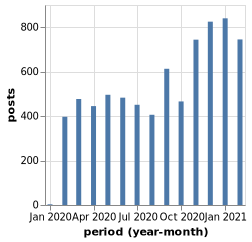

In [107]:
period_posts = combine(
    groupby(transform(posts, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), [:period]),
    nrow => :num_posts)

period_posts |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"sum(num_posts)", axis={title="posts"}},
)

## Topics

In order to find out whether Instagram's algorithm favored some content over the rest, we divided the posts into topics.

**Topics are defined automatically and change with new data**. We use a latent Dirichlet allocation (LDA) to divide the posts into topics. LDA is a commonly-used algorithm that detects topics in documents based on the distribution of words, and allocates a "topic score" to each, so that a document does not have to be linked to just one topic (e.g. a post showing a face and a cat could be classified as 50% topic "faces" and 50% topic "pets").

We divide all posts into twice 8 topics (the number 8 was chosen arbitrarily), first by caption, then by image labels.

### Caption topics

The words in the topics were organized into eight topics. A label was constructed for each topic by interpreting the top words in each topic. Here are posts that score high on an individual caption topic:

In [108]:
gdf = groupby(stack(posts, names(posts, r"cap_top\d+")), :variable);

Based on these posts, and the top words in `topics_caption.csv` the following interpretion was made. In the figure that show the proportion of the topics over time, we can see that the election topics grows in the lasts months:

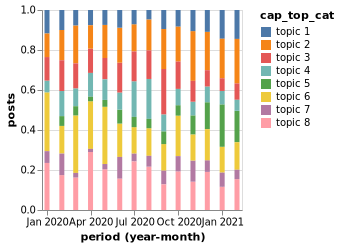

In [109]:
posts.cap_top_cat = recode(string.(posts.cap_top_cat),
    "1" => "topic 1",
    "2" => "topic 2",
    "3" => "topic 3",
    "4" => "topic 4",
    "5" => "topic 5",
    "6" => "topic 6",
    "7" => "topic 7",
    "8" => "topic 8"
);

period_caption = combine(
    groupby(transform(posts, :post_created => ByRow(yearmonth) => :period), [:period, :cap_top_cat]),
    nrow => :count)

period_caption |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"count", axis={title="posts"}, stack=:normalize},
    color={"cap_top_cat:n"})

### Image topics
Images were analyzed with the Google Vision API, and the resulting image tags were organized into eight topics. The post the highest score per topic are listed below:

In [110]:
gdf = groupby(stack(posts, names(posts, r"im_top\d+")), :variable);


Based on these posts, and the top labels in `topics_image.csv` the following interpretation of the image topics was made. Some categories are not very clear (e.g. #3).

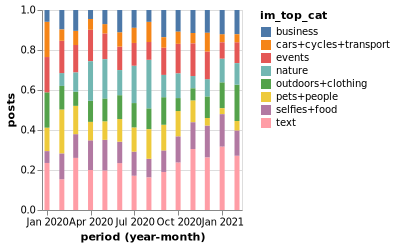

In [111]:
posts.im_top_cat = recode(string.(posts.im_top_cat), 
    "1" => "nature",
    "2" => "text",
    "3" => "events",
    "4" => "outdoors+clothing",
    "5" => "cars+cycles+transport",
    "6" => "pets+people",
    "7" => "selfies+food",
    "8" => "business",
);

period_image = combine(
    groupby(transform(posts, :post_created => ByRow(yearmonth) => :period), [:period, :im_top_cat]),
    nrow => :count)

period_image |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"count", axis={title="posts"}, stack=:normalize},
    color={"im_top_cat:n"})

## Donations

Next we load the donations, and display the number of donations over time.

In [112]:
donations = CSV.File("../data/donations.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;

donations.post_DOW = categorical(map(Dates.dayname, donations.post_created), levels=Dates.dayname.(1:7));
donations.post_HOD = categorical(map(x -> Dates.value(Dates.Hour(x)), donations.post_created));
donations.post_age = (donations.donation_created - donations.post_created) / convert(Dates.Millisecond, Dates.Hour(1));

donations.likes_cat = cut(donations.likes_count, [0, 5, 10, 100, 1000], extend=true);
donations.comments_cat = cut(donations.comments_count, 5);
donations.post_age_cat = cut(donations.post_age, [1, 3, 24], extend=true);

@show(nrow(donations))

nrow(donations) = 38113


38113

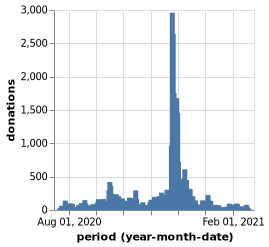

In [113]:
period_donations = combine(
    groupby(transform(donations, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), :period),
    nrow => :num_donations)

period_donations |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonthdate"}, 
    y={"sum(num_donations)", axis={title="donations"}},
)

In [114]:
df = innerjoin(select(donations, Not(:post_created)), posts, on=:post_id);

## RQ1: What posts are overrepresented in the encounters?

To answer this question, we need to describe what posts of Dutch politicians on Instagram are overrepresented in general. This might be due to popularity of the post, or due to biases in Instagram’s recommendations. We are interested in topics, derived from words in the caption and from Google Vision API labels for the post’s images.

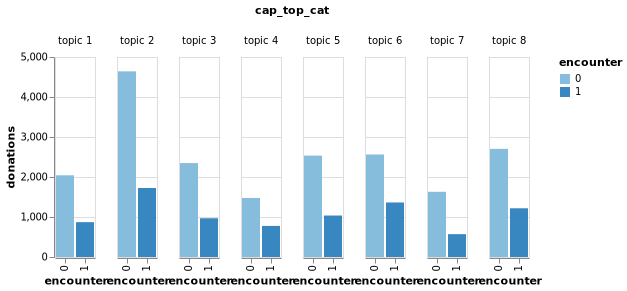

In [115]:
combine(groupby(df, [:cap_top_cat, :encounter]), nrow => :donations) |>
@vlplot(
    :bar,
    column = "cap_top_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = "donations"
)

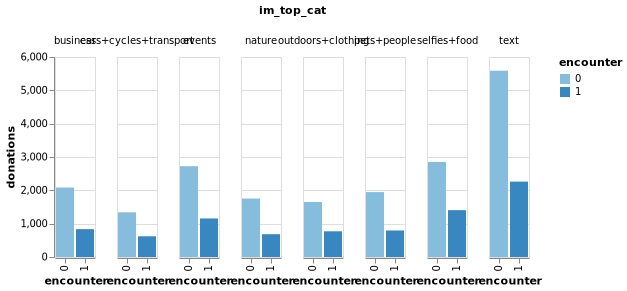

In [116]:
combine(groupby(df, [:im_top_cat, :encounter]), nrow => :donations) |>
@vlplot(
    :bar,
    column = "im_top_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = :donations
)

## RQ2: What posts are overrepresented given their popularity? 
Since overrepresentation is likely to driven by popularity, we analyse what types of posts are overrepresented if we **correct for effects of post popularity**. Remaining variations in post popularity can indicate biases in Instagram’s recommendations. The biases might be limited to the population of donors.

In [117]:
baseline_formula = @formula(encounter ~ 1 
    + log1p(post_age) + log1p(likes_count) + log1p(comments_count) + log1p(follows)
    + post_age_cat + likes_cat + comments_cat
    + post_DOW + post_HOD
    );
baseline_model = glm(baseline_formula, df, Binomial(), LogitLink());
df.pred_popularity = predict(baseline_model, df);

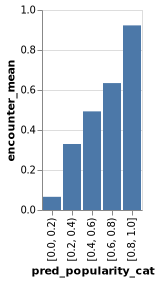

In [118]:
df.pred_popularity_cat = cut(df.pred_popularity, 0:.2:1, extend=true);
combine(groupby(df, :pred_popularity_cat), :encounter=>mean) |> 
    @vlplot(:bar, x="pred_popularity_cat:o", y=:encounter_mean)

This figure shows the encounter frequency is well predicted with the logisitic regression model for popularity. Thus, a large part of the observed encounters can be explained by the presence of competing posts (i.e. time of day or day of week effects), and by the popularity of a post in relation to it's age (through post age, likes and comments). We use this model as a popularity factor, to analyse how much properties of the post content *additionally* changes the probability of encountering a post.

In [119]:
odds(p) = p / (1-p);
logit(p) = log(odds(p));

f2 = @formula(
    encounter ~ 1
        + logit(pred_popularity) # Here we re-use the prediction from the popularity model.
        + (im_top2 + im_top3 + im_top4 + im_top5 + im_top6 + im_top7 + im_top8)
        + (cap_top2 + cap_top3 + cap_top4 + cap_top5 + cap_top6 + cap_top7 + cap_top8)
        + image_adult_categorical + image_medical_categorical + image_racy_categorical + image_spoof_categorical + image_violence_categorical
    );

m2 = glm(f2, df, Binomial(), LogitLink());
df.prediction_RQ2 = predict(m2, df);

Now we can compare the predictions of the baseline popularity model, and the model that uses topic information in addition to the popularity factors. Differences between the predictions are due to topics. If a topic results in a increased chance of an encouter, we call this a positive bias. To compute the bias, we convert the predictions of both models to log-odds using the logit transform, and compute the difference.

In [120]:
df.bias = logit.(df.prediction_RQ2) - logit.(df.pred_popularity);

Now we can analyze the bias per caption topic. We see that posts from the politicians with the topic `politics` and `enjoy` are more likely to be encountered by the donors, and that posts with the topics `personal` and `activating` are less like to been encountered in the feeds of the donors.

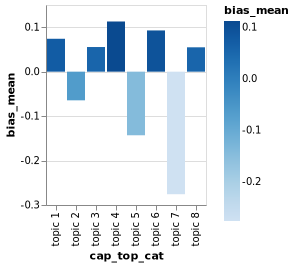

In [121]:
combine(groupby(df, :cap_top_cat), :bias=>mean) |> 
    @vlplot(:bar, x="cap_top_cat:o", y=:bias_mean, color=:bias_mean)

Images with the topics `selfie`, and `indoors` are more likely to reach the donor's feed, while `graphics` and images of `business` are less likely to reach the donor's feed.

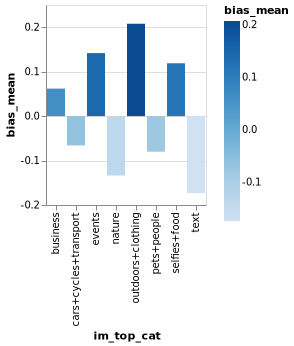

In [122]:
combine(groupby(df, :im_top_cat), :bias=>mean) |> 
    @vlplot(:bar, x="im_top_cat:o", y=:bias_mean, color=:bias_mean)

 Note that this bias might not generalize to other posters than Dutch politicians, and might not generalize to other users than the donors that participated in this experiment.

## RQ3: Is the overrepresentation the same in all subgroups? 

Do the results hold robustly in sub groups? If so, they are more likely to generalize to a wider population. Here we split the data in months, and analyze if the bias is indeed higher for encountered posts than non-encountered posts in each month.

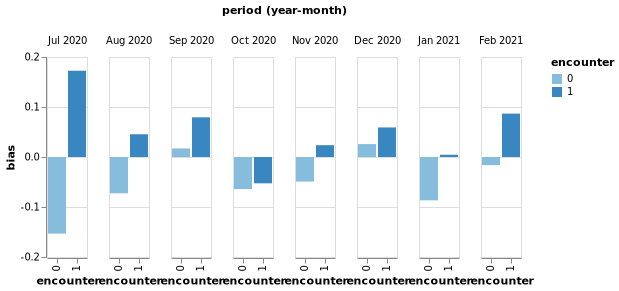

In [123]:
period_bias = combine(
    groupby(transform(df, :post_created => ByRow(t -> floor(t, Dates.Month)) => :period), [:period, :encounter]),
    :bias => mean)

period_bias |> @vlplot(:bar, 
    column={"period:o", timeUnit="yearmonth"}, 
    x = "encounter:o",
    y = {"bias_mean", axis={title="bias"}},
    color = "encounter:o",
)

Within each month, a lower bias is observed for non-encounters than encounters. Thus the bias is robust over different months. Note though that the bias varies strongly from month to month. Since the bias is a function of caption and image topics, this suggests that the *content* has changed from month to month.

## RQ4: Who benefit from these discrepancies? 

Finally, we can estimate per politician how much their posts were benefitting from a consistent algorithm bias of Instagram’s recommendations. Note that this bias can be caused by personalisation; if the donors are of a particular political affiliation they might be presented more with content in line with their views.

In [124]:
parties = CSV.File("../data/parties.csv") |> DataFrame;
rename!(parties, Symbol("IG username") => :ig_username, Symbol("Full name") => :name);
parties = dropmissing(parties[!,[:party, :ig_username, :name]]);
parties.ig_username = categorical(parties.ig_username);
parties.party = categorical(parties.party);

In [125]:
post_bias = combine(groupby(df, [:post_id, :poster_username]), :bias => mean => :bias)
post_bias = innerjoin(post_bias, parties, on=:poster_username => :ig_username)

poster_bias = combine(groupby(post_bias, [:poster_username, :party]), 
    nrow => :num_encounterable_posts, 
    :bias .=> mean)

poster_bias.benefit = poster_bias.bias_mean;
poster_bias = sort(poster_bias, :benefit, rev=true)
first(poster_bias[poster_bias.num_encounterable_posts .> 5,:], 5)

,poster_username,party,num_encounterable_posts,bias_mean,benefit
,Cat…,Cat…,Int64,Float64,Float64
1,klaasdijkhoff,VVD,8,0.277545,0.277545
2,cdavandaag,CDA,6,0.243067,0.243067
3,carla_dik_faber,CU,6,0.197944,0.197944
4,michelrogcda,CDA,18,0.177488,0.177488
5,lianedenhaan,50PLUS,26,0.163872,0.163872


# RQ5: Are the biases present in manually labeled posts?
The goal of the manual labeling is to test some hypotheses we've made by looking at the results of RQ3, e.g. that Insta pushes picts of faces up and picts of food/landscape down. 

In [126]:
manual_labels = CSV.File("../data/labeled_posts.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;
manual_labels = select(manual_labels[manual_labels.done .> 0,:], 
    :post_id, 
    [:text, :face_female, :face_male, :child, :food, :architecture, 
        :nature_plants, :animal, :manufactured_good, :meme, :other].=> ByRow(v -> coalesce(v, 0) > 0), 
    renamecols=false);
@show size(manual_labels)

┌ Warning: thread = 1 warning: only found 18 / 19 columns around data row: 8604. Filling remaining columns with `missing`
└ @ CSV /home/nkb/.julia/packages/CSV/la2cd/src/file.jl:603


size(manual_labels) = (1351, 12)


(1351, 12)

In [127]:
df2 = innerjoin(df, manual_labels, on=:post_id);

f3 = @formula(
    encounter ~ 1
        + logit(pred_popularity) # Here we re-use the prediction from the popularity model.
        + text + face_female + face_male + child + food + architecture 
        + nature_plants + animal + manufactured_good + meme + other
    );

m3 = glm(f3, df2, Binomial(), LogitLink());
df2.prediction_RQ5 = predict(m3, df2);

Here we have constructed a GLM that uses the popularity predictions and the manual labels to predict an encounter. The coefficients of this model are in the appendix; it shows that posts labeled with food and architecture have the strongest positive bias, and memes and text have the strongest negative bias. As before, we can compute the bias as the difference between this model and the baseline popularity model:

In [128]:
df2.bias_labels = logit.(df2.prediction_RQ5) - logit.(df2.pred_popularity);

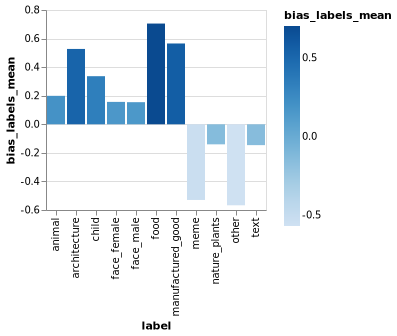

In [129]:
# Aggregate bias per label. Since there can be multiple labels per post it involves some work:
df3 = stack(df2, 
    [:text, :face_female, :face_male, :child, :food, :architecture, 
        :nature_plants, :animal, :manufactured_good, :meme, :other], 
    variable_name=:label);
df3 = df3[df3.value.==true,:];

combine(groupby(df3, :label), :bias_labels => mean) |>
@vlplot(:bar, x="label:o", y=:bias_labels_mean, color=:bias_labels_mean)

The figure above shows the average bias effect. It shows that posts labeled as food have a bias of about $0.8$, which is expressed in log-odds. Thus, the encounter odds for food vs non-food are $\exp(0.8) \approx 2.2$ when correcting for effects post age and engagements. It would me nice to observe this in the raw data.

Visualizing raw counts is difficult, since there are so many donations without an encounter. That dwarfs the results we are interested in. Here is an example where we split the data based on the `food` label. The columns of the plots are based on the popularity model, and indeed we see that the ratio of encounters to non-encounters increases towards the right. The bottom row of the plots is for posts with the `food` label. The absolute counts are so small it is difficult to see that these posts have relatively more encounters.

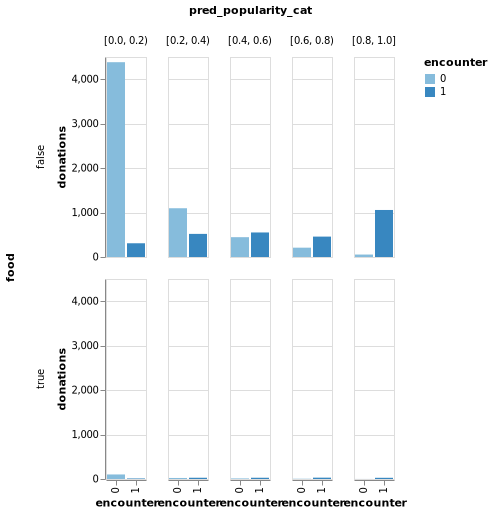

In [130]:
food_raw = combine(groupby(df2, [:pred_popularity_cat, :food, :encounter]), nrow => :donations)
food_raw |>
@vlplot(
    :bar,
    row = "food:o",
    column = "pred_popularity_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = "donations",
)

What we can do however, is to compute the encounter ratio for a combination of a label and a category based on the popularity model. That gives the following heatmap. The first row is for posts that have a low chance of being encountered, for example due to a small number of likes, or from being drowned by other posts. Here we can see that the encounter ratio is low for most categories in the first row, but the `food` category is an exception. Similarly, we can see that posts labeled as `meme` have a low encounter ratio when compared to other labels in the same row.

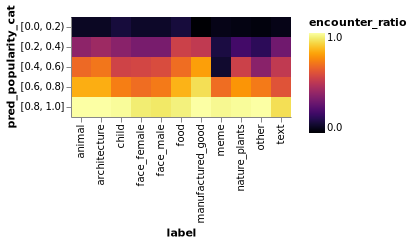

In [131]:
grid = combine(groupby(df3, [:label, :pred_popularity_cat]), nrow => :donations, :encounter => sum)
transform!(grid, [:encounter_sum, :donations] => ByRow((e, d) -> round(e/d, digits=2)) => :encounter_ratio)
grid |> @vlplot(
    :rect,
    x="label:o",
    y="pred_popularity_cat:o",
    color=:encounter_ratio,
    config={range={heatmap={scheme="inferno"}}, view={stroke="transparent"}}
)

# Appendix

#### Image topic 1

![](topic1.jpg)

#### Image topic 2

![](topic2.jpg)

#### Image topic 3

![](topic3.jpg)

#### Image topic 4

![](topic4.jpg)

#### Image topic 5

![](topic5.jpg)

#### Image topic 6

![](topic6.jpg)

#### Image topic 7

![](topic7.jpg)

#### Image topic 8

![](topic8.jpg)

In [132]:
baseline_model

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

encounter ~ 1 + :(log1p(post_age)) + :(log1p(likes_count)) + :(log1p(comments_count)) + :(log1p(follows)) + post_age_cat + likes_cat + comments_cat + post_DOW + post_HOD

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────
                                        Coef.  Std. Error       z  Pr(>|z|)    Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                        7.55926      0.269692    28.03    <1e-99   7.03067      8.08784
log1p(post_age)                   -0.844042     0.0423922  -19.91    <1e-87  -0.92713     -0.760955
log1p(likes_count)                 0.0640608    0.0353074    1.81    0.0696  -0.00514051   0.1332

In [133]:
m2

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

encounter ~ 1 + :(logit(pred_popularity)) + im_top2 + im_top3 + im_top4 + im_top5 + im_top6 + im_top7 + im_top8 + cap_top2 + cap_top3 + cap_top4 + cap_top5 + cap_top6 + cap_top7 + cap_top8 + image_adult_categorical + image_medical_categorical + image_racy_categorical + image_spoof_categorical + image_violence_categorical

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────
                                      Coef.  Std. Error      z  Pr(>|z|)     Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                    -0.208595      0.107554   -1.94    0.0524   -0.419397     0.0022067
logit(pred_popularity)          1.01032       0.0129056 

In [134]:
m3

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

encounter ~ 1 + :(logit(pred_popularity)) + text + face_female + face_male + child + food + architecture + nature_plants + animal + manufactured_good + meme + other

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error      z  Pr(>|z|)    Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              0.277546    0.0816816   3.40    0.0007   0.117452     0.437639
logit(pred_popularity)   1.08718     0.0238563  45.57    <1e-99   1.04042      1.13394
text                    -0.311098    0.0733836  -4.24    <1e-4   -0.454927    -0.167268
face_female              0.0763644   0.074068    1.03    0.3025  -0.0688062    0

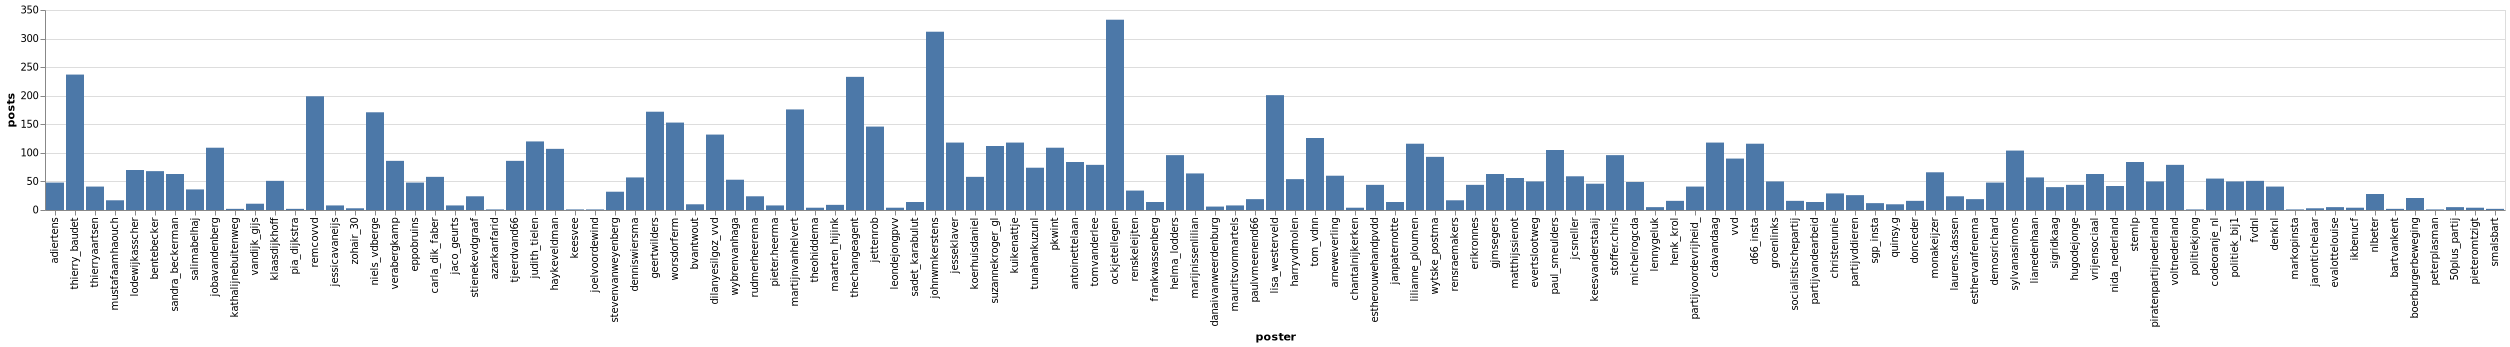

In [135]:
period_posts = combine(
    groupby(transform(posts, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), [:poster_username, :period]),
    nrow => :num_posts)


period_posts |> @vlplot(
    :bar,
    x={"poster_username:o", sort="x", axis={title="poster"}},
    y={"sum(num_posts)", axis={title="posts"}}
)